In [4]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from explicit_functions import dual_control, upstream_repression, no_control, downstream_activation, loss_biological

In [2]:
combined = pd.read_csv('perturb_viz_data_with_background.csv')

In [18]:
perturbed = combined.loc[combined.perturbed == True].sort_values(by='circuit').reset_index(drop=True)
background = combined.loc[combined.perturbed == False].sort_values(by='circuit').reset_index(drop=True)

#Normalize scaled perturbations
perturbed['normalized_km_perturb'] = [1-(perturbed.km_perturb[i] - perturbed.km_perturb.min())/(perturbed.km_perturb.max() - perturbed.km_perturb.min()) for i in range(len(perturbed))] 
perturbed['normalized_kc_perturb'] = [1-(perturbed.kc_perturb[i] - perturbed.kc_perturb.min())/(perturbed.kc_perturb.max() - perturbed.kc_perturb.min()) for i in range(len(perturbed))] 
perturbed['sum_perturb'] = [(perturbed.normalized_km_perturb[i] + perturbed.normalized_kc_perturb[i])  for i in range(len(perturbed))] 
perturbed['normalized_perturbs'] = [ (perturbed.sum_perturb[i] - perturbed.sum_perturb.min())/(perturbed.sum_perturb.max() - perturbed.sum_perturb.min())  for i in range(len(perturbed))] 


In [19]:

features = ['k1', 'k2', 'theta1', 'theta2', 'loss']

x = combined.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1372 samples in 0.001s...
[t-SNE] Computed neighbors for 1372 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1372
[t-SNE] Computed conditional probabilities for sample 1372 / 1372
[t-SNE] Mean sigma: 0.529868
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.991711
[t-SNE] KL divergence after 300 iterations: 0.791857


/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/583887579.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = kmeans.labels_
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/583887579.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = kmeans.labels_
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/583887579.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/2397544555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = kmeans.labels_
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/2397544555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = kmeans.labels_
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/2397544555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Text(0, 0.5, 'TSNE Component 2')

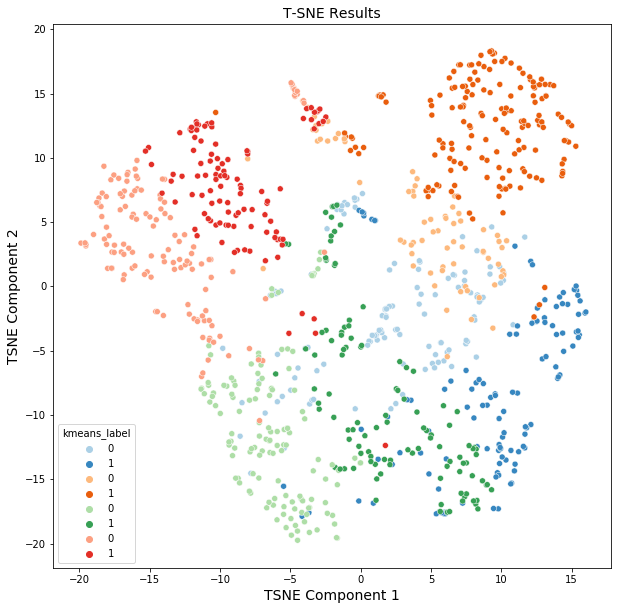

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
circuits = ['Downstream Activation', 'Dual Control', 'No Control',
       'Upstream Repression']
colors = ['Blues', 'Oranges', 'Greens', 'Reds']
num_clusters = 2
for i in range(len(circuits)):
    c_data = perturbed.loc[perturbed.circuit == circuits[i]]

    features = ['k1', 'k2', 'theta1', 'theta2']
    X = c_data.loc[:, features].values

    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
    c_data['kmeans_label'] = kmeans.labels_
    centers = kmeans.cluster_centers_
    sns.scatterplot(x='tsne1', y='tsne2', data = c_data, hue='kmeans_label', ax=ax, palette=colors[i])

# sns.kdeplot(
#     data=perturbed,
#     x="tsne1",
#     y="tsne2",
#     hue="circuit",
#     thresh=.1, ax=ax, alpha=0.5
# )

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/1920273442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = model.fit_predict(X)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/1920273442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['kmeans_label'] = model.fit_predict(X)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82182/1920273442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Text(0, 0.5, 'TSNE Component 2')

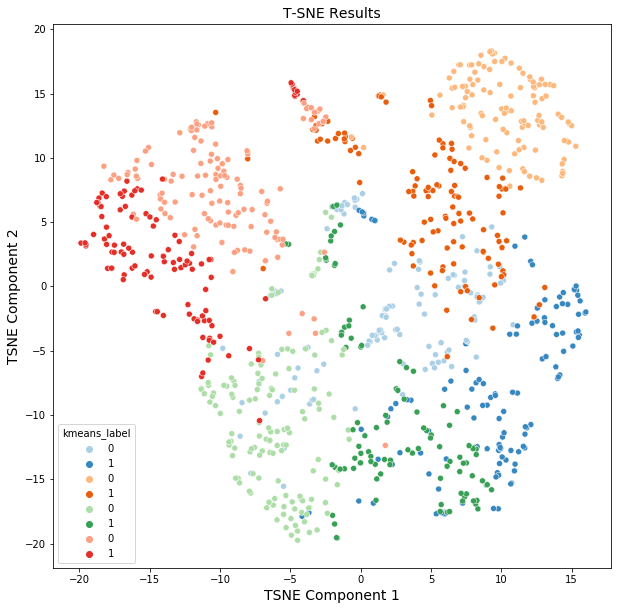

In [37]:
from sklearn.cluster import SpectralClustering
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
circuits = ['Downstream Activation', 'Dual Control', 'No Control',
       'Upstream Repression']
colors = ['Blues', 'Oranges', 'Greens', 'Reds']
num_clusters = 2
for i in range(len(circuits)):
    c_data = perturbed.loc[perturbed.circuit == circuits[i]]

    features = ['k1', 'k2', 'theta1', 'theta2']
    X = c_data.loc[:, features].values

    model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
    c_data['kmeans_label'] = model.fit_predict(X)
    centers = kmeans.cluster_centers_
    sns.scatterplot(x='tsne1', y='tsne2', data = c_data, hue='kmeans_label', ax=ax, palette=colors[i])

# sns.kdeplot(
#     data=perturbed,
#     x="tsne1",
#     y="tsne2",
#     hue="circuit",
#     thresh=.1, ax=ax, alpha=0.5
# )

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

Text(0, 0.5, 'TSNE Component 2')

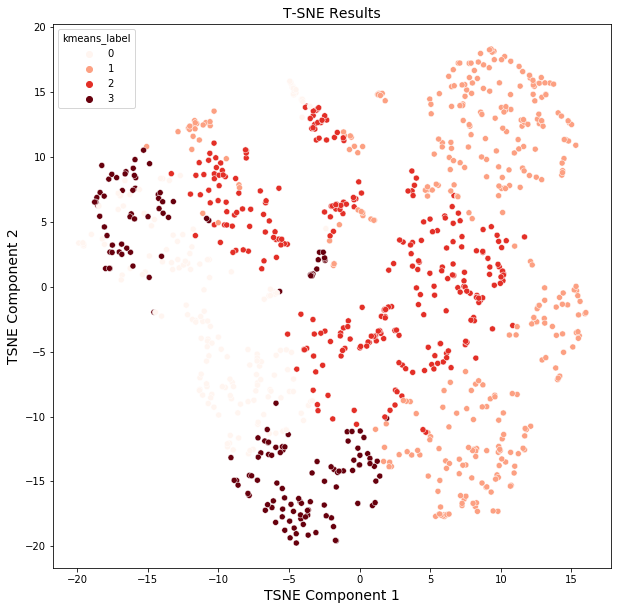

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
circuits = ['Downstream Activation', 'Dual Control', 'No Control',
       'Upstream Repression']
colors = ['Blues', 'Oranges', 'Greens', 'Reds']
num_clusters = 4

c_data = perturbed

features = ['k1', 'k2', 'theta1', 'theta2']
X = c_data.loc[:, features].values

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
c_data['kmeans_label'] = kmeans.labels_
centers = kmeans.cluster_centers_
sns.scatterplot(x='tsne1', y='tsne2', data = c_data, hue='kmeans_label', ax=ax, palette=colors[i])

# sns.kdeplot(
#     data=perturbed,
#     x="tsne1",
#     y="tsne2",
#     hue="circuit",
#     thresh=.1, ax=ax, alpha=0.5
# )

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)